In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.autonotebook import tqdm
from sklearn.datasets import fetch_olivetti_faces
from gpzoo.gp_stuff import NSF, NSF_RBF

/var/folders/k0/dnsdn2ws5vl0xhxl_60p6pcr0000gq/T/ipykernel_73859/1508153585.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [3]:
data, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=97)

In [4]:
Y = (data)*255
Y = Y.astype(int)
Y = torch.tensor(Y)

In [5]:
idx = torch.linspace(-32, 32, 64, dtype=torch.float)
X = torch.cartesian_prod(-idx, idx).flip(dims=[1])
N = X.shape[0]

In [6]:
L =10
M = 32*32
kernel = NSF_RBF(L=L, lengthscale=2)
model = NSF(X=X, y=Y, kernel=kernel, M=M, L=L, jitter=1e-2)
idz = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
model.svgp.Z = nn.Parameter(X[idz])

model.to(device)

NSF(
  (kernel): NSF_RBF()
  (svgp): SVGP(
    (kernel): NSF_RBF()
  )
)

In [7]:
X_train = X.to(device)
Y_train = Y.to(device)

In [8]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
losses = []
for it in tqdm(range(10)):
            
    optimizer.zero_grad()
    pY, qF, qU, pU = model(X_train, E=20)


    ELBO = (pY.log_prob(Y_train)).mean(axis=0).sum()

    ELBO -= torch.sum(distributions.kl_divergence(qU, pU))


    loss = -ELBO
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/luisfcd/gitclones/GPzoo/gpzoo/gp_stuff.py:85: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343685278/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1702.)
  L = torch.cholesky(add_jitter(Kzz, self.jitter))


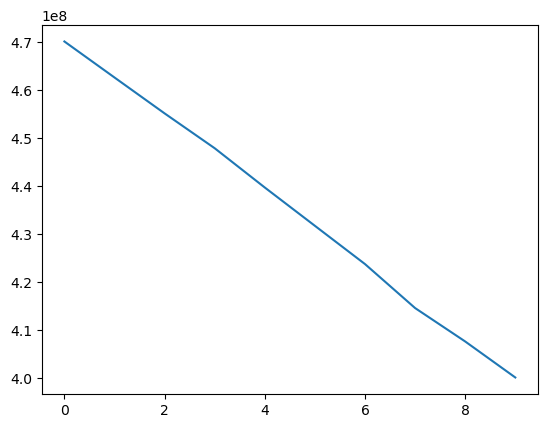

In [10]:
plt.plot(losses)

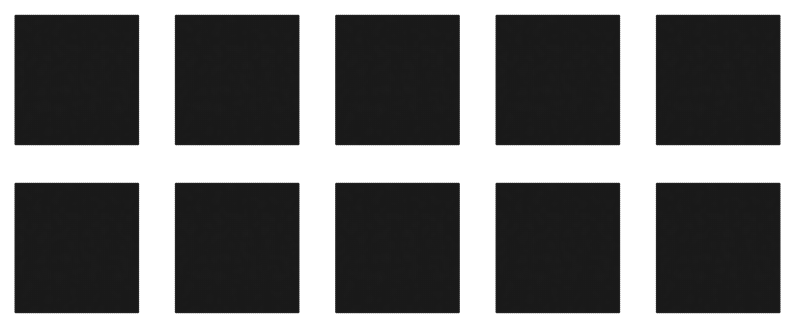

In [11]:
plt.figure(figsize=(10, L*2//5))
for i in range(L):
    plt.subplot(L//5, 5, i+1)
    loading = torch.exp(qF.mean[i]).detach().cpu().numpy()
    plt.scatter(X[:, 0].detach().cpu().numpy(), X[:,1].detach().cpu().numpy(), c=loading, cmap='gray',  vmin=0, vmax=10, alpha=0.9, s=2)

    plt.axis('off')